

# Step 1 - Preliminaries #



In [1]:

import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor


# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

# Mute warnings
warnings.filterwarnings('ignore')


## Data Preprocessing ##


In [2]:
def load_data():
    # Read data
    data_dir = Path("G:/MLbook/Housing_price_prediction")
    df_train = pd.read_csv(data_dir / "train.csv", index_col="Id")
    df_test = pd.read_csv(data_dir / "test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test


### Clean Data ###


In [3]:
data_dir = Path("G:/MLbook/Housing_price_prediction")
df = pd.read_csv(data_dir / "train.csv", index_col="Id")

df.Exterior2nd.unique()
df.MSSubClass

Id
1       60
2       20
3       60
4       70
5       60
        ..
1456    60
1457    20
1458    70
1459    20
1460    20
Name: MSSubClass, Length: 1460, dtype: int64

In [4]:
def clean(df):
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})
    # Some values of GarageYrBlt are corrupt, so we'll replace them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df


### Encode the Statistical Data Type ###


In [5]:

# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]


# The ordinal (ordered) categorical features 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df


### Handle Missing Values ###

Handling missing values now will make the feature engineering go more smoothly. We'll impute `0` for missing numeric values and `"None"` for missing categorical values. You might like to experiment with other imputation strategies. In particular, you could try creating "missing value" indicators: `1` whenever a value was imputed and `0` otherwise.

In [6]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df


## Load Data ##


In [7]:
df_train, df_test = load_data()

In [8]:
# Peek at the values
#display(df_train)
#display(df_test)

# Display information about dtypes and missing values
display(df_train.info())
#display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 n

None

## Establish Baseline ##



In [9]:
models={}
def score_dataset(X, y, models_to_check=[]):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in X.select_dtypes(["category"]):
            X[colname] = X[colname].cat.codes
        # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    #Linear regressor
    lin_reg = LinearRegression()
    #Decision Tree Regressor
    tree_reg = DecisionTreeRegressor()
    #Random forest regressor
    forest_reg = RandomForestRegressor()
    
    models_to_check = [lin_reg, tree_reg, forest_reg]
    model_scores = {}
    
    for model in models_to_check:
        models[model] = cross_val_score(model, X, log_y,
                                scoring = "neg_mean_squared_error", cv = 5)

        model_scores[model] = np.sqrt(-(models[model].mean())) #negatbive sign - for reasons refer the book pg:73
    return model_scores


In [10]:
X = df_train.copy()
y = X.pop("SalePrice")

baseline_scores = score_dataset(X, y)
for model in baseline_scores:
    print(f"Baseline score {model}: {baseline_scores[model]:.5f} RMSLE")

Baseline score LinearRegression(): 0.15276 RMSLE
Baseline score DecisionTreeRegressor(): 0.20958 RMSLE
Baseline score RandomForestRegressor(): 0.14014 RMSLE




# Step 2 - Feature Utility Scores #


In [11]:
a,b = df_train['Alley'].factorize()
a

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [12]:

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Let's look at our feature scores again:

In [13]:
pd.set_option("display.max_rows",500)

In [14]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores

OverallQual         5.714573e-01
Neighborhood        5.262205e-01
GrLivArea           4.303952e-01
YearBuilt           4.079737e-01
LotArea             3.944684e-01
TotalBsmtSF         3.685360e-01
GarageArea          3.615423e-01
GarageCars          3.523117e-01
BsmtQual            3.308034e-01
KitchenQual         3.246795e-01
ExterQual           3.240025e-01
FirstFlrSF          2.825031e-01
MSSubClass          2.813486e-01
YearRemodAdd        2.740316e-01
GarageYrBlt         2.722127e-01
FullBath            2.632172e-01
GarageFinish        2.624690e-01
LotFrontage         2.185875e-01
FireplaceQu         2.181614e-01
GarageType          2.115533e-01
TotRmsAbvGrd        2.084654e-01
Foundation          1.911287e-01
OpenPorchSF         1.902657e-01
Fireplaces          1.720900e-01
SecondFlrSF         1.675903e-01
HeatingQC           1.649465e-01
Exterior2nd         1.602566e-01
BsmtFinSF1          1.549404e-01
BsmtFinType1        1.536238e-01
Exterior1st         1.333076e-01
MSZoning  

In [15]:
def drop_uninformative(df, mi_scores):
    return df.loc[:, mi_scores > 0.0]


In [16]:
X = df_train.copy()
y = X.pop("SalePrice")
X = drop_uninformative(X, mi_scores)

#score_dataset(X, y)



# Step 3 - Create Features #


In [17]:
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X




## Create Features with Pandas ##


In [18]:

def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance
    # X["TotalOutsideSF"] = \
    #     df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + \
    #     df.Threeseasonporch + df.ScreenPorch
    return X


def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X


def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X


def break_down(df):
    X = pd.DataFrame()
    X["MSClass"] = df.MSSubClass.str.split("_", n=1, expand=True)[0]
    return X


def group_transforms(df):
    X = pd.DataFrame()
    X["MedNhbdArea"] = df.groupby("Neighborhood")["GrLivArea"].transform("median")
    return X



## k-Means Clustering ##


In [19]:

cluster_features = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]


def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd


## Principal Component Analysis ##


In [20]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


In [22]:

def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


pca_features = [
    "GarageAre",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

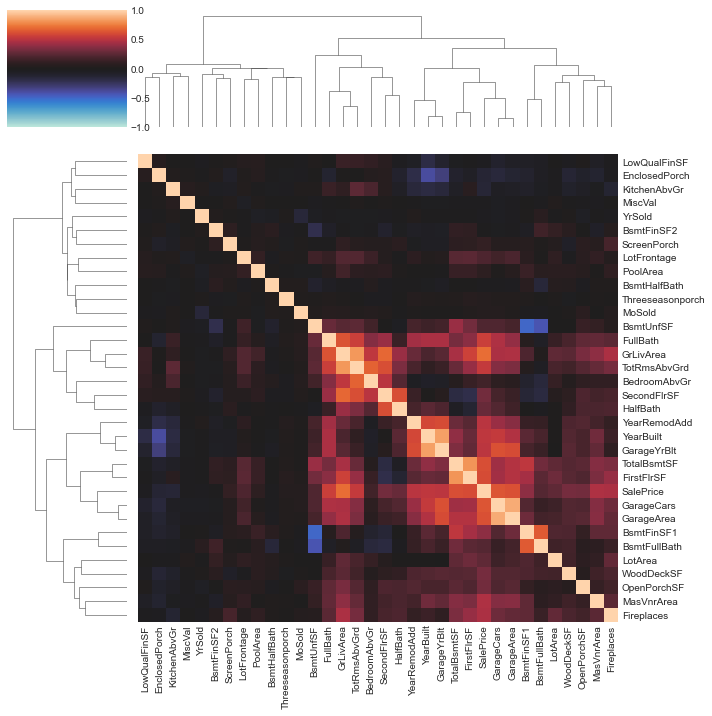

In [23]:
def corrplot(df, method="pearson", annot=True, **kwargs):
    sns.clustermap(
        df.corr(method),
        vmin=-1.0,
        vmax=1.0,
        cmap="icefire",
        method="complete",
        annot=annot,
        **kwargs,
    )


corrplot(df_train, annot=None)



### PCA Application - Indicate Outliers ###



In [24]:
def indicate_outliers(df):
    X_new = pd.DataFrame()
    X_new["Outlier"] = (df.Neighborhood == "Edwards") & (df.SaleCondition == "Partial")
    return X_new


## Target Encoding ##



In [25]:

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            #print(idx_encode,idx_train)
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        print(X_encoded)
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded




## Create Final Feature Set ##

Now let's combine everything together. Putting the transformations into separate functions makes it easier to experiment with various combinations. The ones I left uncommented I found gave the best results. You should experiment with you own ideas though! Modify any of these transformations or come up with some of your own to add to the pipeline.

In [26]:
def create_features(df, df_test=None):
    X = df.copy()
    y = X.pop("SalePrice")
    mi_scores = make_mi_scores(X, y)

    # Combine splits if test data is given
    #
    # If we're creating features for test set predictions, we should
    # use all the data we have available. After creating our features,
    # we'll recreate the splits.
    if df_test is not None:
        X_test = df_test.copy()
        X_test.pop("SalePrice")
        X = pd.concat([X, X_test])

    #Mutual Information
    X = drop_uninformative(X, mi_scores)

    #Transformations
    X = X.join(mathematical_transforms(X))
    X = X.join(interactions(X))
    X = X.join(counts(X))
    # X = X.join(break_down(X))
    X = X.join(group_transforms(X))

    #Clustering
    # X = X.join(cluster_labels(X, cluster_features, n_clusters=20))
    # X = X.join(cluster_distance(X, cluster_features, n_clusters=20))

    #PCA
    X = X.join(pca_inspired(X))
    # X = X.join(pca_components(X, pca_features))
    # X = X.join(indicate_outliers(X))

    X = label_encode(X)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    #Target Encoder
    encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
    X = X.join(encoder.fit_transform(X, y, cols=["MSSubClass"]))
    if df_test is not None:
        X_test = X_test.join(encoder.transform(X_test))

    if df_test is not None:
        return X, X_test
    else:
        return X


df_train, df_test = load_data()
X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

score_dataset(X_train, y_train)

      MSSubClass_encoded
Id                      
1          239516.446215
2          185723.883274
3          239516.446215
4          166639.379087
5          239516.446215
...                  ...
1456       240928.838526
1457       183654.853847
1458       164348.875596
1459       183654.853847
1460       183654.853847

[1460 rows x 1 columns]


{LinearRegression(): 0.14448221586626417,
 DecisionTreeRegressor(): 0.207511718435289,
 RandomForestRegressor(): 0.1376832732906787}

In [27]:
X_train.shape

(1460, 87)

# Step 4 - Hyperparameter Tuning #



### Random Search CV

In [28]:
models

{LinearRegression(): array([-0.01608613, -0.0272621 , -0.01869832, -0.01702415, -0.03761046]),
 DecisionTreeRegressor(): array([-0.04287227, -0.04627371, -0.04253372, -0.04102672, -0.04690936]),
 RandomForestRegressor(): array([-0.01668618, -0.02245549, -0.02235632, -0.01708579, -0.01961349]),
 LinearRegression(): array([-0.01567479, -0.02300435, -0.01877791, -0.01554973, -0.03136877]),
 DecisionTreeRegressor(): array([-0.03622672, -0.05578152, -0.04538143, -0.03445815, -0.04345775]),
 RandomForestRegressor(): array([-0.01542149, -0.02352691, -0.01898884, -0.01744868, -0.01939751])}

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

X_train = create_features(df_train)
y_train = df_train.loc[:, "SalePrice"]

param_distribs = {
    'n_estimators': randint(low = 1, high = 200),
    'max_features': randint(low = 30, high = 70)
}

rnd_search = RandomizedSearchCV(list(models.keys())[-1], param_distributions = param_distribs,
                               n_iter = 10, cv = 5, scoring = 'neg_mean_squared_error',
                               random_state = 42)
rnd_search.fit(X_train, y_train)

      MSSubClass_encoded
Id                      
1          239516.446215
2          185723.883274
3          239516.446215
4          166639.379087
5          239516.446215
...                  ...
1456       240928.838526
1457       183654.853847
1458       164348.875596
1459       183654.853847
1460       183654.853847

[1460 rows x 1 columns]


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CF3E974C10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001CF3DF7D9A0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [30]:
cvres = rnd_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

28288.349171534835 {'max_features': 68, 'n_estimators': 180}
29254.537238598892 {'max_features': 58, 'n_estimators': 15}
27864.445737570637 {'max_features': 37, 'n_estimators': 189}
28262.391557599534 {'max_features': 50, 'n_estimators': 103}
28291.328499918578 {'max_features': 48, 'n_estimators': 75}
28406.899673429874 {'max_features': 40, 'n_estimators': 88}
28609.753748693714 {'max_features': 65, 'n_estimators': 104}
28268.152405831665 {'max_features': 53, 'n_estimators': 131}
28541.3842858673 {'max_features': 51, 'n_estimators': 53}
28593.523744738464 {'max_features': 31, 'n_estimators': 88}


In [31]:
rnd_search.best_params_

{'max_features': 37, 'n_estimators': 189}

In [32]:
X_train, X_test = create_features(df_train, df_test)
y_train = df_train.loc[:, "SalePrice"]

forest_reg = RandomForestRegressor(**rnd_search.best_params_)
# XGB minimizes MSE, but competition loss is RMSLE
# So, we need to log-transform y to train and exp-transform the predictions
forest_reg.fit(X_train, np.log(y))
predictions = np.exp(forest_reg.predict(X_test))

output = pd.DataFrame({'Id': X_test.index, 'SalePrice': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

      MSSubClass_encoded
Id                      
1          239516.446215
2          185723.883274
3          239516.446215
4          166639.379087
5          239516.446215
...                  ...
1456       240928.838526
1457       183654.853847
1458       164348.875596
1459       183654.853847
1460       183654.853847

[1460 rows x 1 columns]
Your submission was successfully saved!
